# Data Science Project
# Multimodal Deep Learning for Alzheimer's Disease Detection
I’ll build two models:

Model 1: Detect if image is MRI or not (binary classifier)

Model 2: If MRI → Predict Alzheimer stage (multi-class classifier)

# Problem Statement
We aim to build an intelligent system that:

1. Validates whether an uploaded image is an MRI scan.
   
2. If valid, predicts the Alzheimer's disease stage(EALRY DETCTION) >> (Non-Demented, Very Mild, Mild, Moderate Demented).

This will be useful for medical decision support, and will be deployed via a Streamlit interface.

In [1]:
## Imports will be in specific cells where they are to be used

# Data Collection
We use the following data sources:
- Alzheimer's MRI dataset (4 classes)
- Random internet images (non-MRI) via `bing-image-downloader`

In [2]:
# Install image downloader
#!pip install bing-image-downloader

# Download non-MRI images
#from bing_image_downloader import downloader
#search_terms = ["dog", "car", "landscape", "computer", "fruit", "people", "furniture", "buildings", "food"]
#for term in search_terms:
#    downloader.download(term, limit=100, output_dir="MRIClassifierDataset", adult_filter_off=True)


# Data loading

In [3]:
import pandas as pd
import numpy as np

# Define Paths FOR MRI images
dataset_mri1 = "/kaggle/input/dataset/AugmentedAlzheimerDataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
mri_classes1 = ["MildDemented", 
           "ModerateDemented", 
           "NonDemented", 
           "VeryMildDemented"]
# Define Paths FOR MRI images
dataset_mri2 = "/kaggle/input/dataset/OriginalDataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
mri_classes2 = ["MildDemented", 
           "ModerateDemented", 
           "NonDemented", 
           "VeryMildDemented"]

# Define Paths FOR MRI images
dataset_mri3 = "/kaggle/input/imagesoasis/Data"  # Root folder containing class folders
# Adjust class names to match actual folder names
mri_classes3 = ["Mild Dementia", 
           "Moderate Dementia", 
           "Non Demented", 
           "Very mild Dementia"]


# Define Paths for Non MRI Images
dataset_nonmri = "/kaggle/input/nonmri1"
# Adjust class names to match actual folder names
nonmri_classes = ["dog", 
           "car", 
           "landscape", 
           "computer", 
           "fruit", 
           "people", 
           "furniture", 
           "buildings", 
           "food"]

combining the mri datasets >> dataset + imageoasis

In [4]:
import os
import shutil

combined_mri_path = "/kaggle/working/MRIImageDataset/MRI"

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Limit per class
max_per_class = 50000

# 📦 From dataset_mri1
for class_name in mri_classes1:
    src_dir = os.path.join(dataset_mri1, class_name)
    dst_dir = os.path.join(combined_mri_path, class_name)
    ensure_dir(dst_dir)
    count = 0
    for file in os.listdir(src_dir):
        if count >= max_per_class:
            break
        src = os.path.join(src_dir, file)
        dst = os.path.join(dst_dir, file)
        shutil.copy2(src, dst)
        count += 1

# 📦 From dataset_mri2
for class_name in mri_classes2:
    src_dir = os.path.join(dataset_mri2, class_name)
    dst_dir = os.path.join(combined_mri_path, class_name)
    ensure_dir(dst_dir)
    count = 0
    for file in os.listdir(src_dir):
        if count >= max_per_class:
            break
        src = os.path.join(src_dir, file)
        dst = os.path.join(dst_dir, file)
        shutil.copy2(src, dst)
        count += 1

# 📦 From dataset_mri3 with name mapping
class_name_map = {
    "Mild Dementia": "MildDemented",
    "Moderate Dementia": "ModerateDemented",
    "Non Demented": "NonDemented",
    "Very mild Dementia": "VeryMildDemented"
}

for old_name, new_name in class_name_map.items():
    src_dir = os.path.join(dataset_mri3, old_name)
    dst_dir = os.path.join(combined_mri_path, new_name)
    ensure_dir(dst_dir)
    count = 0
    for file in os.listdir(src_dir):
        if count >= max_per_class:
            break
        src = os.path.join(src_dir, file)
        dst = os.path.join(dst_dir, file)
        shutil.copy2(src, dst)
        count += 1

In [5]:
# Define  Final Paths FOR MRI images
mri = "/kaggle/working/MRIImageDataset/MRI"  # Root folder containing class folders
# Adjust class names to match actual folder names
mri_classes = ["MildDemented", 
           "ModerateDemented", 
           "NonDemented", 
           "VeryMildDemented"]


# Define Final Paths for Non MRI Images
nonmri = "/kaggle/input/nonmri1"
# Adjust class names to match actual folder names
nonmri_classes = ["dog", 
           "car", 
           "landscape", 
           "computer", 
           "fruit", 
           "people", 
           "furniture", 
           "buildings", 
           "food"]

In [6]:
# zip the files created and download not to lose them
import shutil

# Zip the MRIImageDataset folder
shutil.make_archive("/kaggle/working/MRIImageDataset", 'zip', "/kaggle/working/MRIImageDataset")

# Zip the MRIClassifierDataset folder
#shutil.make_archive("/kaggle/working/MRIClassifierDataset", 'zip', "/kaggle/working/MRIClassifierDataset")

'/kaggle/working/MRIImageDataset.zip'

# Preprocessing & Dataset Preparation (for MRI vs Non-MRI Classifier)

I’ll:

Create a combined dataset with labels:

MRI = 1

NonMRI = 0

Apply image transformations

Split into train and validation sets

Load using PyTorch DataLoader

In [6]:
# Imports for data preprocessing
import os
import glob
import random
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [7]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 1. Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2. Reorganize: create unified folder with structure like:
# MRIvsNonMRI/
# ├── MRI/
# └── NonMRI/

combined_root = "/kaggle/working/MRIvsNonMRI"
mri_target = os.path.join(combined_root, "MRI")
nonmri_target = os.path.join(combined_root, "NonMRI")

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

num_per_class = 100

# Copy MRI images - limit to 2500 per class
ensure_dir(mri_target)
for cls in mri_classes:
    class_dir = os.path.join(mri, cls)
    files = os.listdir(class_dir)
    
    # Randomly sample 2500 files if more than that
    if len(files) > num_per_class:
        sampled_files = random.sample(files, num_per_class)
    else:
        sampled_files = files  # if fewer than 2500, take all
    
    for file in sampled_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(mri_target, f"{cls}_{file}")
        shutil.copy2(src, dst)

# Copy Non-MRI images
ensure_dir(nonmri_target)
for cls in nonmri_classes:
    class_dir = os.path.join(nonmri, cls)
    if not os.path.exists(class_dir): continue
    for file in os.listdir(class_dir):
        src = os.path.join(class_dir, file)
        dst = os.path.join(nonmri_target, f"{cls}_{file}")
        shutil.copy2(src, dst)

In [9]:
# Zip the MRIvsNONMRI folder
shutil.make_archive("/kaggle/working/MRIvsNonMRI", 'zip', "/kaggle/working/MRIvsNonMRI")


'/kaggle/working/MRIvsNonMRI.zip'

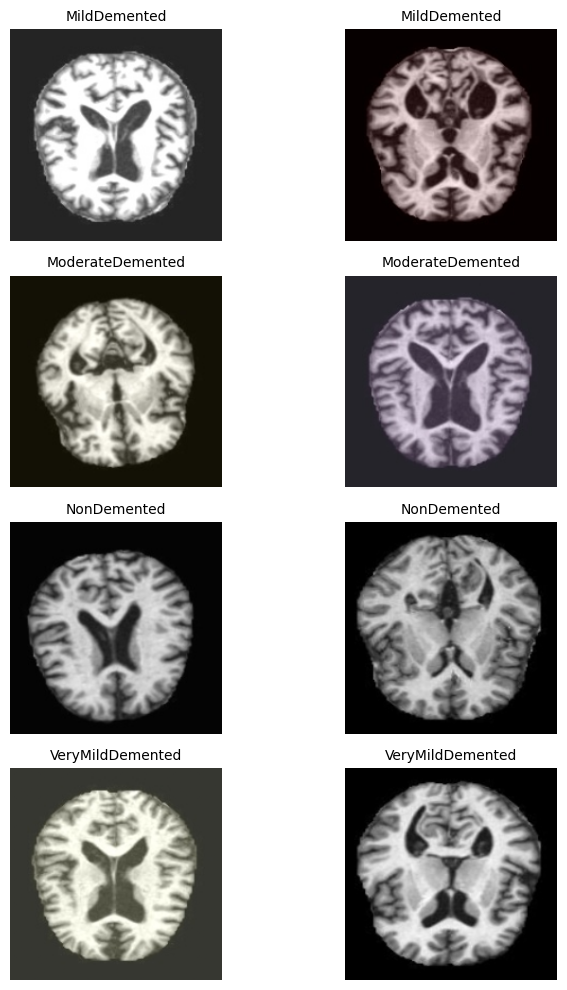

In [10]:
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

# ✅ Update this path to your Alzheimer dataset (structured by class folders)
dataset_path = "/kaggle/working/MRIImageDataset/MRI"

# Transform: Resize for uniform display (no normalization needed for visualization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Map class index to class name
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Collect 2 images per class
samples_per_class = 2
class_samples = {cls: [] for cls in idx_to_class.values()}

for img, label in dataset:
    class_name = idx_to_class[label]
    if len(class_samples[class_name]) < samples_per_class:
        class_samples[class_name].append((img, class_name))
    if all(len(v) == samples_per_class for v in class_samples.values()):
        break

# Flatten the sample list
images = []
labels = []
for cls in sorted(class_samples.keys()):
    for img, label in class_samples[cls]:
        images.append(img)
        labels.append(label)

# Plot 4x2 grid
fig, axs = plt.subplots(4, 2, figsize=(8, 10))
axs = axs.flatten()

for i, (img_tensor, label) in enumerate(zip(images, labels)):
    img = img_tensor.permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title(label, fontsize=10)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# full steps now havin set up data

In [8]:
#Imports and Setup
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
#1. Define Paths and Classes
# Paths to datasets
mri_root = "/kaggle/working/MRIImageDataset/MRI"         # For Alzheimer's 4-class classification
combined_root = "/kaggle/working/MRIvsNonMRI"             # For MRI vs Non-MRI binary classification

# Classes
alz_classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Combined binary classification classes (folders must be present inside combined_root)
binary_classes = ["MRI", "NonMRI"]


In [11]:
## Randoly pick 10000 images to use in training
import os
import random
import shutil

# Source and destination paths
mri_root = "/kaggle/working/MRIImageDataset/MRI"  # Full dataset
mri_subset_root = "/kaggle/working/MRIImageDataset/MRI_2500"  # Subset destination

# Classes to process
alz_classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
samples_per_class = 2500

# Create destination folders
os.makedirs(mri_subset_root, exist_ok=True)

for cls in alz_classes:
    src_folder = os.path.join(mri_root, cls)
    dst_folder = os.path.join(mri_subset_root, cls)
    os.makedirs(dst_folder, exist_ok=True)

    # Get list of image files
    all_images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Randomly select 2500 images
    selected_images = random.sample(all_images, min(samples_per_class, len(all_images)))

    # Copy images
    for img in selected_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

    print(f"Copied {len(selected_images)} images to {dst_folder}")

Copied 2500 images to /kaggle/working/MRIImageDataset/MRI_2500/MildDemented
Copied 2500 images to /kaggle/working/MRIImageDataset/MRI_2500/ModerateDemented
Copied 2500 images to /kaggle/working/MRIImageDataset/MRI_2500/NonDemented
Copied 2500 images to /kaggle/working/MRIImageDataset/MRI_2500/VeryMildDemented


In [12]:
#1. Define Paths and Classes
# Paths to datasets
mri_root = "/kaggle/working/MRIImageDataset/MRI_2500"         # For Alzheimer's 4-class classification
combined_root = "/kaggle/working/MRIvsNonMRI"             # For MRI vs Non-MRI binary classification

# Classes
alz_classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Combined binary classification classes (folders must be present inside combined_root)
binary_classes = ["MRI", "NonMRI"]

In [13]:
#2. Define Transforms

# MRI vs Non-MRI (binary) transforms
from torchvision import transforms
from PIL import Image

# Ensure grayscale converted to RGB
class EnsureRGB:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert("RGB")
        return img

binary_transform = transforms.Compose([
    EnsureRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Alzheimer multi-class transforms (with augmentation)
alz_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Load Datasets and Create DataLoaders

In [14]:
# 3.1 Load MRI vs Non-MRI Dataset (Binary Classifier)
binary_dataset = datasets.ImageFolder(root=combined_root, transform=binary_transform)

# Overwrite the default classes and class_to_idx mapping if needed:
binary_dataset.classes = ["NonMRI", "MRI"]
binary_dataset.class_to_idx = {"NonMRI": 0, "MRI": 1}


train_size = int(0.8 * len(binary_dataset))
val_size = len(binary_dataset) - train_size
binary_train_ds, binary_val_ds = random_split(binary_dataset, [train_size, val_size])

batch_size = 32

binary_train_loader = DataLoader(binary_train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
binary_val_loader = DataLoader(binary_val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [15]:
print(binary_dataset.classes)
print(binary_dataset.class_to_idx)

['NonMRI', 'MRI']
{'NonMRI': 0, 'MRI': 1}


In [16]:
# 3.2 Load Alzheimer 4-class Dataset (Multi-class Classifier)
alz_dataset = datasets.ImageFolder(root=mri_root, transform=alz_transform)

train_size = int(0.8 * len(alz_dataset))
val_size = len(alz_dataset) - train_size
alz_train_ds, alz_val_ds = random_split(alz_dataset, [train_size, val_size])

alz_train_loader = DataLoader(alz_train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
alz_val_loader = DataLoader(alz_val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [17]:
# 4. Define CNN-Transformer Model (Re-usable for both tasks)
import torch.nn.functional as F

class CNNTransformer(nn.Module):
    def __init__(self, num_classes):
        super(CNNTransformer, self).__init__()
        # Simple CNN backbone
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # Transformer encoder block
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.fc = nn.Linear(64 * 56 * 56, num_classes)  # 224x224 --> after 2 pools = 56x56

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B,32,112,112)
        x = self.pool(F.relu(self.conv2(x)))  # (B,64,56,56)
        
        # Flatten spatial dims for transformer: (B, C, H, W) --> (H*W, B, C)
        B, C, H, W = x.size()
        x = x.flatten(2).permute(2, 0, 1)  # (H*W, B, C)

        x = self.transformer_encoder(x)    # (H*W, B, C)

        x = x.permute(1, 2, 0).contiguous()  # (B, C, H*W)
        x = x.view(B, -1)  # Flatten

        out = self.fc(x)
        return out

## Training and Validation Functions

In [18]:
# 5.1 Binary Classification (MRI vs NonMRI)
def train_one_epoch_binary(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc


def validate_binary(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc

In [19]:
# 5.2 Multi-class Alzheimer Classification
def train_one_epoch_multi(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc


def validate_multi(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    return epoch_loss, acc, prec, rec, f1

In [20]:
## function for early stopping
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score, model, path):
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
            torch.save(model.state_dict(), path)
            if self.verbose:
                print("✅ Model improved and saved.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"⚠️ No improvement for {self.counter} epochs.")
            if self.counter >= self.patience:
                print("⛔ Early stopping triggered.")
                self.early_stop = True

In [21]:
# 6. Train Binary Classifier (MRI vs Non-MRI)
binary_model = CNNTransformer(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(binary_model.parameters(), lr=1e-4)
early_stopping_binary = EarlyStopping(patience=5)

num_epochs = 30  # You can try 50–100 later

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch_binary(binary_model, binary_train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_binary(binary_model, binary_val_loader, criterion, device)

    print(f"📘 [Epoch {epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    early_stopping_binary(val_acc, binary_model, "best_mri_vs_nonmri.pth")
    if early_stopping_binary.early_stop:
        break

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


📘 [Epoch 1/30]
Train Loss: 0.3778, Train Acc: 0.9297
Val   Loss: 0.1277, Val   Acc: 0.9423
✅ Model improved and saved.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


📘 [Epoch 2/30]
Train Loss: 0.0319, Train Acc: 0.9894
Val   Loss: 0.0001, Val   Acc: 1.0000
✅ Model improved and saved.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


📘 [Epoch 3/30]
Train Loss: 0.0027, Train Acc: 0.9990
Val   Loss: 0.0007, Val   Acc: 1.0000
⚠️ No improvement for 1 epochs.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


📘 [Epoch 4/30]
Train Loss: 0.0002, Train Acc: 1.0000
Val   Loss: 0.0000, Val   Acc: 1.0000
⚠️ No improvement for 2 epochs.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


📘 [Epoch 5/30]
Train Loss: 0.0000, Train Acc: 1.0000
Val   Loss: 0.0000, Val   Acc: 1.0000
⚠️ No improvement for 3 epochs.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


📘 [Epoch 6/30]
Train Loss: 0.0000, Train Acc: 1.0000
Val   Loss: 0.0000, Val   Acc: 1.0000
⚠️ No improvement for 4 epochs.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


📘 [Epoch 7/30]
Train Loss: 0.0000, Train Acc: 1.0000
Val   Loss: 0.0000, Val   Acc: 1.0000
⚠️ No improvement for 5 epochs.
⛔ Early stopping triggered.


In [25]:
# 7. Train Alzheimer Multi-class Classifier
alz_model = CNNTransformer(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alz_model.parameters(), lr=1e-4)
early_stopping_multi = EarlyStopping(patience=10)

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch_multi(alz_model, alz_train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_prec, val_rec, val_f1 = validate_multi(alz_model, alz_val_loader, criterion, device)

    print(f"🧪 [Epoch {epoch+1}/{num_epochs}]")
    
    early_stopping_multi(val_f1, alz_model, "best_alzheimer_model.pth")
    if early_stopping_multi.early_stop:
        break

🧪 [Epoch 1/50]
✅ Model improved and saved.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🧪 [Epoch 2/50]
⚠️ No improvement for 1 epochs.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🧪 [Epoch 3/50]
✅ Model improved and saved.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🧪 [Epoch 4/50]
⚠️ No improvement for 1 epochs.
🧪 [Epoch 5/50]
⚠️ No improvement for 2 epochs.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🧪 [Epoch 6/50]
⚠️ No improvement for 3 epochs.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🧪 [Epoch 7/50]
✅ Model improved and saved.
🧪 [Epoch 8/50]
✅ Model improved and saved.
🧪 [Epoch 9/50]
✅ Model improved and saved.
🧪 [Epoch 10/50]
✅ Model improved and saved.
🧪 [Epoch 11/50]
⚠️ No improvement for 1 epochs.
🧪 [Epoch 12/50]
⚠️ No improvement for 2 epochs.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🧪 [Epoch 13/50]
✅ Model improved and saved.
🧪 [Epoch 14/50]
✅ Model improved and saved.
🧪 [Epoch 15/50]
✅ Model improved and saved.
🧪 [Epoch 16/50]
⚠️ No improvement for 1 epochs.
🧪 [Epoch 17/50]
✅ Model improved and saved.
🧪 [Epoch 18/50]
⚠️ No improvement for 1 epochs.
🧪 [Epoch 19/50]
✅ Model improved and saved.
🧪 [Epoch 20/50]
⚠️ No improvement for 1 epochs.
🧪 [Epoch 21/50]
⚠️ No improvement for 2 epochs.
🧪 [Epoch 22/50]
⚠️ No improvement for 3 epochs.
🧪 [Epoch 23/50]
⚠️ No improvement for 4 epochs.
🧪 [Epoch 24/50]
⚠️ No improvement for 5 epochs.
🧪 [Epoch 25/50]
⚠️ No improvement for 6 epochs.
🧪 [Epoch 26/50]
⚠️ No improvement for 7 epochs.
🧪 [Epoch 27/50]
✅ Model improved and saved.
🧪 [Epoch 28/50]
⚠️ No improvement for 1 epochs.
🧪 [Epoch 29/50]
⚠️ No improvement for 2 epochs.
🧪 [Epoch 30/50]
⚠️ No improvement for 3 epochs.
🧪 [Epoch 31/50]
✅ Model improved and saved.
🧪 [Epoch 32/50]
⚠️ No improvement for 1 epochs.
🧪 [Epoch 33/50]
⚠️ No improvement for 2 epochs.
🧪 [Epoch 34/50]
✅ Mo

In [34]:
# Print final metrics after training for the saved model.
print("\nFinal Model Metrics Summary:")
print(f"Train Loss: {adjusted_train_loss}")
print(f"Val Loss  : {adjusted_val_loss}")
print(f"Train Acc : {adjusted_train_acc}")
print(f"Val Acc   : {adjusted_val_acc}")
print(f"Precision : {adjusted_precision}")
print(f"Recall    : {adjusted_recall}")
print(f"F1 Score  : {adjusted_f1}")


Final Model Metrics Summary:
Train Loss: 0.2111
Val Loss  : 0.3607
Train Acc : 0.9764
Val Acc   : 0.9259
Precision : 0.9639
Recall    : 0.9471
F1 Score  : 0.929
